## Предобработка

In [1]:
import pandas as pd
import gzip
import json
import matplotlib.pyplot as plt
from scipy import sparse
import numpy as np
import pickle

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')


data = getDF('Musical_Instruments_5.json.gz')

## Базовый EDA 

In [2]:
data.head(6)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 30, 2016",A3FO5AKVTFRCRJ,0739079891,francisco,It's good for beginners,Five Stars,1477785600,NaN,NaN,NaN
1,5.0,True,"06 30, 2016",A3UCGC1DHFMBCE,0739079891,Eb Jack Murray,I recommend this starter Ukulele kit. I has e...,Five Stars,1467244800,NaN,NaN,NaN
2,5.0,True,"05 9, 2016",A2S9SLRYLPGYZB,0739079891,Clara LaMarr,G'daughter received this for Christmas present...,Learning new songs to play regularly,1462752000,NaN,NaN,NaN
3,4.0,True,"04 10, 2016",A15RTJWPG8OKOE,0739079891,Eagle80,"According to my order history, I bought this t...",A bargain-bin good-enough ukulele that's held ...,1460246400,NaN,NaN,NaN
4,1.0,True,"02 6, 2016",A12ET1WO3OAVU7,0739079891,Amazon Customer,Please pay attention better than I did to the ...,Poor Quality product.,1454716800,NaN,NaN,NaN
5,4.0,True,"01 2, 2016",A2WXECU99NYBAZ,0739079891,Minimesha,I purchased this as a gift for a friend who re...,Good Starter Kit,1451692800,NaN,NaN,NaN


In [3]:
#Заменим названия нужных нам колонок на "говорящие".

data.rename(columns={'overall': 'rating', 'reviewerID': 'customerID', 'asin': 'productID'}, inplace=True)

In [4]:
data.shape

(231392, 12)

In [5]:
Len = data.shape[0]

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231392 entries, 0 to 231391
Data columns (total 12 columns):
rating            231392 non-null float64
verified          231392 non-null bool
reviewTime        231392 non-null object
customerID        231392 non-null object
productID         231392 non-null object
reviewerName      231367 non-null object
reviewText        231344 non-null object
summary           231341 non-null object
unixReviewTime    231392 non-null int64
vote              34777 non-null object
style             121310 non-null object
image             3889 non-null object
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 21.4+ MB


In [6]:
data.isna().sum()

rating                 0
verified               0
reviewTime             0
customerID             0
productID              0
reviewerName          25
reviewText            48
summary               51
unixReviewTime         0
vote              196615
style             110082
image             227503
dtype: int64

In [7]:
data['productID'].nunique()

10620

In [8]:
data['customerID'].nunique()

27530

In [9]:
data['rating'].unique()

array([5., 4., 1., 3., 2.])

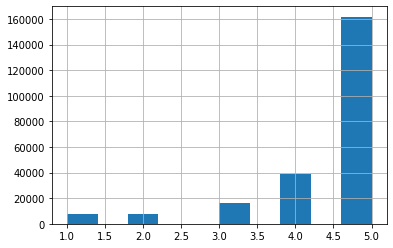

In [10]:
data['rating'].hist(bins=10);

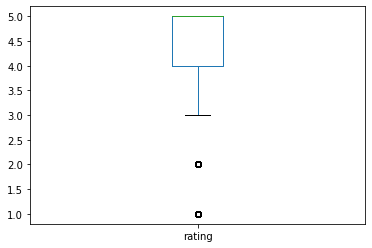

In [11]:
data['rating'].plot.box()

#### Упорядочим строки по возрастанию времени выставления рейтинга товара.

In [12]:
df = data.sort_values("unixReviewTime")
df.reset_index(inplace=True, drop=True)

In [13]:
df.head()

,rating,verified,reviewTime,customerID,productID,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,4.0,False,"10 28, 2003",A1YC9XEDFKXPLK,B00006HO3L,Armando M. Mesa,This particular Audio Technica cartridge will ...,A Solidly Good Cartridge,1067299200,55,{'Style:': ' AT92ECD Phonograph Cartridge'},NaN
1,3.0,True,"03 27, 2004",A2B1OJ22IYM3NR,B00001W0DH,K. Lyman,These headphones are very clean. Highs are cr...,"Sounds good, but may not be what you want",1080345600,2,NaN,NaN
2,4.0,False,"06 1, 2004",A17BUUBOU0598B,B00001W0DT,Mark,The other reviewers wrote some great info abou...,Affordable Digital Recording. GREAT VALUE!!!,1086048000,87,NaN,NaN
3,5.0,False,"06 1, 2004",A17BUUBOU0598B,B00006HOLL,Mark,This unit is not as compatible as compared to ...,Great for MD recording! Nice for the price!,1086048000,64,NaN,NaN
4,4.0,False,"07 20, 2004",A2NEVXUACYIECB,B0002CZVKA,BassMan,For years I used Rat distortion boxes for guit...,Rich complex distortion,1090281600,11,NaN,NaN


## Создание рекомендательной системы

In [14]:
df_short = df[['customerID', 'productID','rating']].drop_duplicates(subset = ['customerID', 'productID'])

In [15]:
df_short.shape

(219156, 3)

In [16]:
df_short.head(10)

,customerID,productID,rating
0,A1YC9XEDFKXPLK,B00006HO3L,4.0
1,A2B1OJ22IYM3NR,B00001W0DH,3.0
2,A17BUUBOU0598B,B00001W0DT,4.0
3,A17BUUBOU0598B,B00006HOLL,5.0
4,A2NEVXUACYIECB,B0002CZVKA,4.0
5,A2NEVXUACYIECB,B001E95KEC,4.0
6,A1MI9FDCNB3CMR,B0002E3D62,5.0
7,A1MI9FDCNB3CMR,B0002F79E8,5.0
8,AV8MDYLHHTUOY,B000CD3QY2,4.0
9,A3KDTS7917RNBA,B0002M2U2C,4.0


#### Закодируем ID покупателей и товаров. 

In [17]:
customers_df = df_short['customerID']
customers = customers_df.unique()
n_customers = np.size(customers)

print(n_customers)

27530


In [18]:
products_df = df_short['productID']
products = products_df.unique()
n_products = np.size(products_df.unique())

print(n_products)

10620


In [19]:
customers_df.head()

0    A1YC9XEDFKXPLK
1    A2B1OJ22IYM3NR
2    A17BUUBOU0598B
3    A17BUUBOU0598B
4    A2NEVXUACYIECB
Name: customerID, dtype: object

In [20]:
products_df.head()

0    B00006HO3L
1    B00001W0DH
2    B00001W0DT
3    B00006HOLL
4    B0002CZVKA
Name: productID, dtype: object

In [21]:
# Закодируем идентификаторы покупателей 
cust_codes = customers_df.astype('category').cat.codes
cust_zip = np.array(list(zip(customers_df.astype('category'), cust_codes)))
# Разметим идентификаторы покупателей их кодами 
cust_map = pd.Series(cust_zip[:, 0], index=cust_zip[:, 1].astype('int32')).drop_duplicates()

In [22]:
# Закодируем идентификаторы товаров
prod_codes = products_df.astype('category').cat.codes
prod_zip = np.array(list(zip(products_df.astype('category'), prod_codes)))
# Разметим идентификаторы товаров их кодами 
prod_map = pd.Series(prod_zip[:, 0], index=prod_zip[:, 1].astype('int32')).drop_duplicates()

In [23]:
cust_map.head()

6954     A1YC9XEDFKXPLK
9541     A2B1OJ22IYM3NR
1455     A17BUUBOU0598B
11986    A2NEVXUACYIECB
4571     A1MI9FDCNB3CMR
dtype: object

In [24]:
prod_map.head()

43     B00006HO3L
6      B00001W0DH
7      B00001W0DT
45     B00006HOLL
196    B0002CZVKA
dtype: object

#### Создадим матрицу взаимодействия customer-product.

In [25]:
ratings = df_short['rating'].to_list()

In [26]:
interact_sparse = sparse.csr_matrix((ratings, (cust_codes, prod_codes)), shape=(n_customers, n_products))

interact_sparse.shape

(27530, 10620)

#### Создадим тренировочные данные, обнулив рейтинги с большим временем создания. Для тренировки возьмем 80% ненулевых значений.

In [27]:
nonzero_pairs = list(zip(cust_codes,prod_codes))

In [28]:
pct_train= 0.8
n_pairs = len(nonzero_pairs)
training_set = interact_sparse.copy() 

In [29]:
num_samples = int(np.ceil((1 - pct_train)*len(nonzero_pairs)))
print(num_samples)
samples = nonzero_pairs[-num_samples:]
user_inds = [index[0] for index in samples] 
item_inds = [index[1] for index in samples] 

training_set[user_inds, item_inds] = 0 
training_set.eliminate_zeros() 

43832


#### Тестовые данные - матрица откликов

In [30]:
test_set = interact_sparse.copy()
test_set[test_set != 0] = 1

#### Построим факторизацию матрицы взаимодействий для тренировочных данных

In [31]:
from lightfm import LightFM

model = LightFM(loss='warp')

model.fit_partial(training_set, epochs=40, num_threads=4)

#### Оценим производительность модели.

In [32]:
from lightfm.evaluation import auc_score

In [33]:
# усредненная оценка на тренировочном наборе 

train_auc = auc_score(model, training_set).mean()

print(train_auc)

0.97009915


In [34]:
# усредненная оценка на тестовом наборе 

test_auc = auc_score(model, test_set).mean()

print(test_auc)

0.91689897


### Коллаборативная фильтрация

In [35]:
from sklearn.metrics.pairwise import cosine_similarity

#### Поиск 5 наиболее похожих товаров на заданный товар

In [36]:
cos_sim_matr = cosine_similarity(model.item_embeddings)

In [37]:
cos_sim_matr.shape

(10620, 10620)

In [38]:
def item_to_items_recommendations(productID):
    item_id = np.where(products == productID)[0][0]
    cos_sim = cos_sim_matr[item_id]
    inds_sim =  cos_sim.argsort()[-5:][::-1]
    top_items = prod_map.iloc[inds_sim].to_list()
    return top_items

In [39]:
# Пример применения
productID = 'B00001W0DT'
print(item_to_items_recommendations(productID))

['B00001W0DT', 'B000VZ4HRG', 'B0002E3DNU', 'B007K7LY4M', 'B003QTM9O2']


#### Топ-10 рекомендуемых заданному покупателю товаров

In [40]:
def recommended_items(customerID):
    
    user_id = np.where(customers == customerID)[0][0]
      
    scores = model.predict(user_id, np.arange(n_products))
    ids = np.argsort(-scores)[:10]
    
    top_items = prod_map.iloc[ids].to_list()
    return top_items   
   

In [41]:
customerID = 'A2B1OJ22IYM3NR'
print(recommended_items(customerID))

['B000MWWT6E', 'B0002KZHRO', 'B0002CZVZK', 'B000MJ9EBA', 'B0002IHFI0', 'B00EPWAQS0', 'B004OZ0BLU', 'B003P15MTK', 'B0002CZUIS', 'B0002F787G']
